In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime

### Load style and content

In [2]:
#CONTENT_FILENAME = "inputs/imperial.mp3"
#STYLE_FILENAME = "inputs/usa.mp3"
# CONTENT_FILENAME = "inputs/04 Bruno Mars - Treasure.mp3"
# STYLE_FILENAME = "inputs/08 Godot - Fragrance of Dark Coffee.mp3"
CONTENT_FILENAME = "inputs/those_things_10.mp3"
STYLE_FILENAME = "inputs/treasure_10.mp3"
#STYLE_FILENAME = "inputs/godot_10.mp3"

In [3]:
start = time.time()
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))
end = time.time()
print("Total time: {}".format(end-start))

Total time: 0.0204012393951416


In [4]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename, sr=None)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    #S = np.log1p(np.abs(S[:,:430]))  
    S = np.log1p(np.abs(S[:,:]))
    return S, fs

In [5]:
start = time.time()

a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]
end = time.time()
print("Total time: {}".format(end-start))

Total time: 0.4923288822174072


In [6]:
print(N_SAMPLES)
print(N_CHANNELS)

862
1025


### Visualize spectrograms for content and style tracks

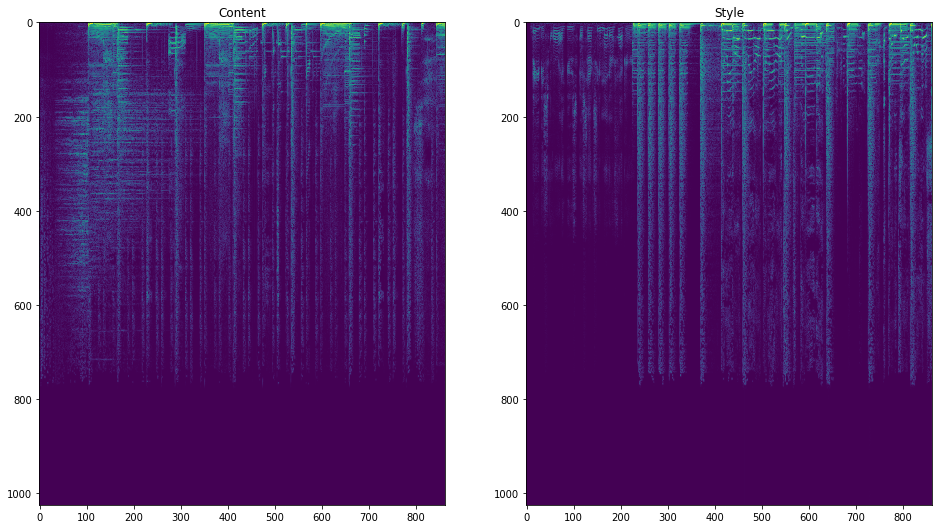

In [7]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.title('Content')
#plt.imshow(a_content[:400,:])
plt.imshow(a_content[:,:])
plt.subplot(1, 2, 2)
plt.title('Style')
# plt.imshow(a_style[:400,:])
plt.imshow(a_style[:,:])
plt.show()

### Compute content and style feats

In [8]:
print("Compute content and style feats")

start = time.time()

N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std


g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    print("kernel_tf: {}".format(kernel_tf))
    print("kernel_tf.shape: {}".format(kernel_tf.shape))

    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES
    
end = time.time()
print("Total time: {}".format(end-start))

Compute content and style feats
kernel_tf: Tensor("kernel:0", shape=(1, 11, 1025, 4096), dtype=float32, device=/device:CPU:0)
kernel_tf.shape: (1, 11, 1025, 4096)
Total time: 8.126323223114014


### Optimize

In [9]:
print("Optimize")
start = time.time()

from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss: {}'.format(loss.eval()))
        #print 'Final loss:', loss.eval()
        result = x.eval()

        
end = time.time()
print("Total time: {}".format(end-start))

Optimize
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 630.230225
  Number of iterations: 300
  Number of functions evaluations: 317
Final loss: 630.230224609375
Total time: 70.32348036766052


### Invert spectrogram and save the result

In [10]:
start = time.time()

a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/out_big.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

end = time.time()
print("Total time: {}".format(end-start))

Total time: 42.44545102119446


In [11]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

outputs/out_big.wav


### Visualize spectrograms

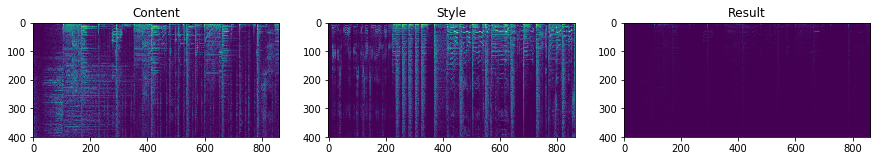

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()

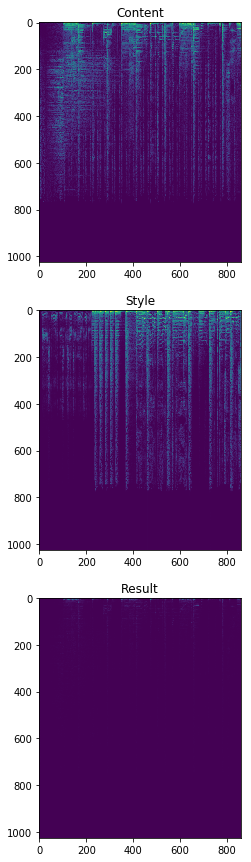

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title('Content')
plt.imshow(a_content[:,:])
plt.subplot(3,1,2)
plt.title('Style')
plt.imshow(a_style[::])
plt.subplot(3,1,3)
plt.title('Result')
plt.imshow(a[:,:])
plt.show()